In [1]:
%pip install -q numpy==1.24.4 seaborn matplotlib portalocker>=2.0.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------- -------------------------------- 2.4/12.8 MB 13.4 MB/s eta 0:00:01
     -------------- ------------------------- 4.7/12.8 MB 12.4 MB/s eta 0:00:01
     ------------------------- -------------- 8.1/12.8 MB 14.0 MB/s eta 0:00:01
     ----------------------------------- --- 11.5/12.8 MB 14.7 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 14.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
%pip install -q torch==2.0.1+cu118 torchtext==0.15.2 -f https://download.pytorch.org/whl/torch_stable.html

Note: you may need to restart the kernel to use updated packages.


In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, GloVe
from torchtext.datasets import IMDB
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from typing import Tuple
import time

# 1. Set style, random seeds, and device

In [5]:
# Test numpy and PyTorch integration
print(np.__version__)
print(torch.__version__)

1.24.4
2.0.1+cu118


In [6]:
SEED = 1234
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# 2. Define tokenizer, pipelines, and helper functions

In [7]:
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

In [8]:
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for (_label, _text) in batch:
        # Map labels: 1 (Negative) -> 0, 2 (Positive) -> 1
        label_list.append(0 if _label == 1 else 1)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        lengths.append(len(processed_text))

    return (torch.tensor(label_list, dtype=torch.int64).to(device),
            nn.utils.rnn.pad_sequence(text_list, batch_first=True).to(device),
            torch.tensor(lengths, dtype=torch.int64).to(device))

# 3. Load dataset and build vocabulary

In [9]:
MAX_VOCAB_SIZE = 25_000

vocab = build_vocab_from_iterator(
    yield_tokens(IMDB(split='train')),
    max_tokens=MAX_VOCAB_SIZE,
    specials=['<unk>', '<pad>']
)

vocab.set_default_index(vocab['<unk>'])

text_pipeline = lambda x: vocab(tokenizer(x))

# 4. Re-instantiate train/test iterators and create DataLoaders

In [10]:
train_iter = IMDB(split='train')
test_iter = IMDB(split='test')

BATCH_SIZE = 64

train_dataloader = DataLoader(train_iter, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              collate_fn=collate_batch)
test_dataloader = DataLoader(test_iter, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False, 
                             collate_fn=collate_batch)

5. Load vectors from Glove

In [11]:
vectors = GloVe(name='6B', dim=100)

# 6. Define the RNN model

In [12]:
class RNN(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_size: int,
                 output_size: int, pad_idx: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.GRU(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
        self.embedding.weight.data.copy_(vectors.get_vecs_by_tokens(vocab.get_itos()))
        self.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

    def forward(self, text: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        embedded = self.embedding(text)
        packed_embedded = pack_padded_sequence(embedded,
                                            lengths.cpu(),
                                            batch_first=True,
                                            enforce_sorted=False)
        packed_output, _ = self.rnn(packed_embedded)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        output = F.adaptive_max_pool1d(output.transpose(1, 2), 1).squeeze(dim=-1)
        return self.fc(output)

# 7. Training and evaluation functions

In [13]:
def train_epoch(model: nn.Module, dataloader: DataLoader,
                optimizer: optim.Optimizer, criterion: nn.Module) -> Tuple[float, float]:
    model.train()
    total_loss = total_acc = total_count = batch_count = 0
    start = time.time()

    for labels, text, lengths in dataloader:
        optimizer.zero_grad()
        predictions = model(text, lengths)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += (predictions.argmax(dim=1) == labels).sum().item()
        total_count += labels.size(0)
        batch_count += 1

    train_loss = total_loss / batch_count
    train_acc = total_acc / total_count

    end = time.time()
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Time: {end-start:.2f}s")

    return train_loss, train_acc


def evaluate(model: nn.Module, dataloader: DataLoader, criterion: nn.Module) -> Tuple[float, float]:
    model.eval()
    total_loss = total_acc = total_count = batch_count = 0
    start = time.time() 

    with torch.no_grad():
        for labels, text, lengths in dataloader:
            predictions = model(text, lengths)
            loss = criterion(predictions, labels)
            total_loss += loss.item()
            total_acc += (predictions.argmax(dim=1) == labels).sum().item()
            total_count += labels.size(0)
            batch_count += 1

    valid_loss = total_loss / batch_count
    valid_acc = total_acc / total_count

    end = time.time()
    print(f"Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc*100:.2f}% | Time: {end-start:.2f}s")

    return valid_loss, valid_acc

# 8. Instantiate model, loss, and optimizer

In [14]:
model = RNN(len(vocab), 100, 256, 2, vocab['<pad>']).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-5)

print(model)

RNN(
  (embedding): Embedding(25000, 100, padding_idx=1)
  (rnn): GRU(100, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


# 9. Training loop

In [15]:
N_EPOCHS = 20

train_losses, valid_losses, train_accus, valid_accus = [], [], [], []

for epoch in range(N_EPOCHS):
    print(f"Epoch: {epoch+1:02d}")
    
    train_loss, train_acc = train_epoch(model, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, test_dataloader, criterion)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accus.append(train_acc)
    valid_accus.append(valid_acc)

Epoch: 01
Train Loss: 0.5529 | Train Acc: 72.54% | Time: 74.23s
Valid Loss: 0.7498 | Valid Acc: 50.00% | Time: 41.36s
Epoch: 02
Train Loss: 0.5155 | Train Acc: 73.56% | Time: 73.97s
Valid Loss: 0.6369 | Valid Acc: 55.41% | Time: 40.24s
Epoch: 03
Train Loss: 0.4397 | Train Acc: 81.22% | Time: 74.14s
Valid Loss: 0.5045 | Valid Acc: 74.84% | Time: 39.87s
Epoch: 04
Train Loss: 0.3670 | Train Acc: 84.76% | Time: 74.58s
Valid Loss: 0.4764 | Valid Acc: 77.00% | Time: 38.06s
Epoch: 05
Train Loss: 0.3288 | Train Acc: 86.17% | Time: 73.41s
Valid Loss: 0.4234 | Valid Acc: 80.52% | Time: 39.10s
Epoch: 06
Train Loss: 0.3075 | Train Acc: 87.25% | Time: 73.82s
Valid Loss: 0.3808 | Valid Acc: 82.84% | Time: 39.85s
Epoch: 07
Train Loss: 0.2847 | Train Acc: 88.18% | Time: 73.94s
Valid Loss: 0.4156 | Valid Acc: 81.14% | Time: 39.42s
Epoch: 08
Train Loss: 0.2719 | Train Acc: 88.92% | Time: 73.58s
Valid Loss: 0.3973 | Valid Acc: 82.42% | Time: 39.11s
Epoch: 09
Train Loss: 0.2600 | Train Acc: 89.42% | Time:

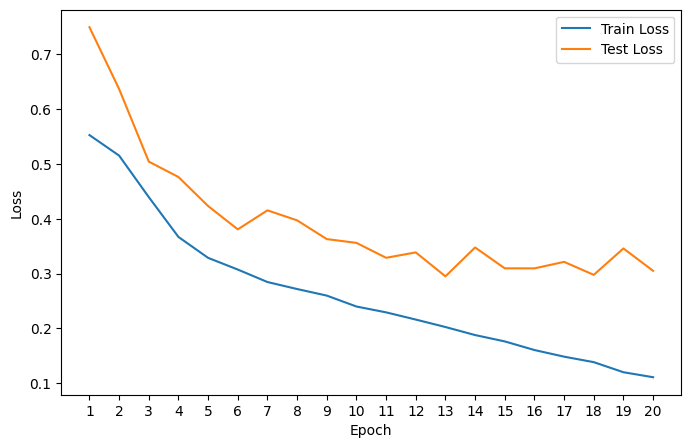

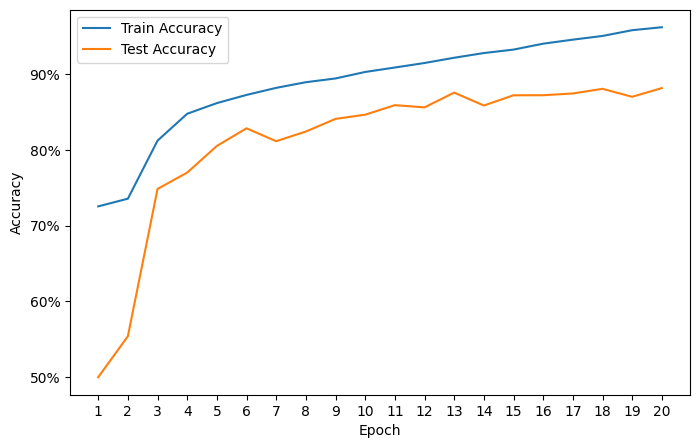

In [31]:
from matplotlib.ticker import FuncFormatter

# Plot Loss Curves
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Test Loss')
plt.xticks(range(N_EPOCHS))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda val, pos: f"{val +1:.0f}"))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy Curves
plt.figure(figsize=(8,5))
plt.plot(train_accus, label='Train Accuracy')
plt.plot(valid_accus, label='Test Accuracy')
plt.xticks(range(N_EPOCHS))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda val, pos: f"{val +1:.0f}"))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda val, pos: f"{val * 100:.0f}%"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 10. Inference/Prediction function

In [32]:
def predict_sentiment(model: nn.Module, text: str) -> np.ndarray:
    model.eval()
    with torch.no_grad():
        # Convert the input text to indices
        tokens = torch.tensor(text_pipeline(text), dtype=torch.int64).unsqueeze(0).to(device)
        # length must be the actual number of tokens
        length = torch.tensor([tokens.size(1)], dtype=torch.int64).to(device)
        
        predictions = model(tokens, length)
        probabilities = F.softmax(predictions, dim=1).squeeze()

    return probabilities.cpu().numpy()


Text: The plot was engaging, and the characters were incredibly well-written.
Prediction: Positive


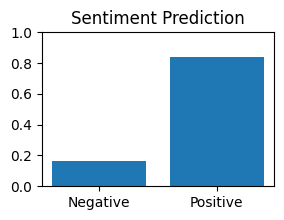

------------------------------------------------------------
Text: I couldn't sit through the entire movie; it was that boring.
Prediction: Negative


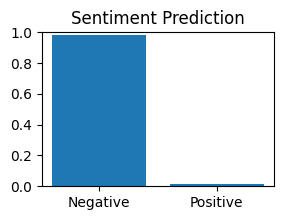

------------------------------------------------------------
Text: Absolutely loved it! The visuals were stunning, and the story was captivating.
Prediction: Positive


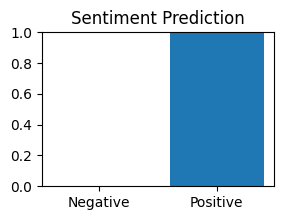

------------------------------------------------------------
Text: This movie was a complete mess. The acting was terrible, and the pacing was off.
Prediction: Negative


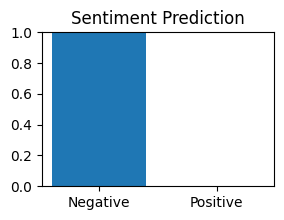

------------------------------------------------------------
Text: A brilliant masterpiece that kept me on the edge of my seat.
Prediction: Positive


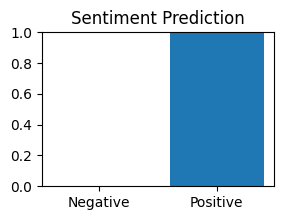

------------------------------------------------------------
Text: The movie was okay, but it didn't really stand out.
Prediction: Negative


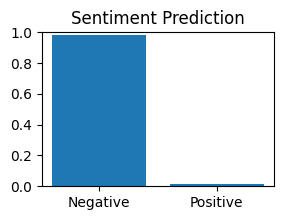

------------------------------------------------------------
Text: Some parts were engaging, but others felt a bit dull.
Prediction: Negative


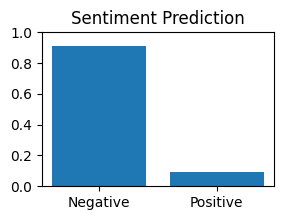

------------------------------------------------------------
Text: I liked the characters, but the plot could have been stronger.
Prediction: Positive


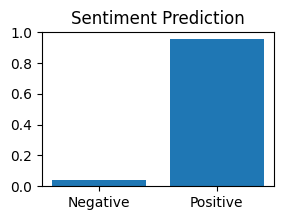

------------------------------------------------------------
Text: The cinematography was great, but the pacing was way off.
Prediction: Positive


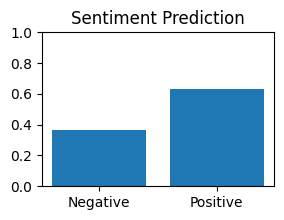

------------------------------------------------------------
Text: Not bad, but not great either. Just average.
Prediction: Negative


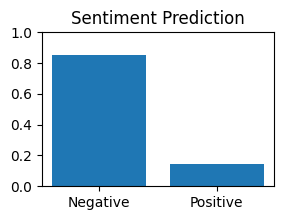

------------------------------------------------------------


In [36]:
test_sentences = [
    "The plot was engaging, and the characters were incredibly well-written.",
    "I couldn't sit through the entire movie; it was that boring.",
    "Absolutely loved it! The visuals were stunning, and the story was captivating.",
    "This movie was a complete mess. The acting was terrible, and the pacing was off.",
    "A brilliant masterpiece that kept me on the edge of my seat.",
    "The movie was okay, but it didn't really stand out.",
    "Some parts were engaging, but others felt a bit dull.",
    "I liked the characters, but the plot could have been stronger.",
    "The cinematography was great, but the pacing was way off.",
    "Not bad, but not great either. Just average."
]

for sentence in test_sentences:
    probs = predict_sentiment(model, sentence)
    sentiment = 'Positive' if probs[1] > probs[0] else 'Negative'
    print(f"Text: {sentence}")
    print(f"Prediction: {sentiment}")

    plt.figure(figsize=(3, 2))
    plt.bar(['Negative', 'Positive'], probs)
    plt.title('Sentiment Prediction')
    plt.ylim(0, 1)
    plt.show()

    print("---"*20)